In [1]:
input_dim = 13
num_clusters = 6

ntrials = 0 #set to run a different analysis of the same explanations
lg = 3.0 #lambda_global

model_file = "/home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt"

import csv
import json
import numpy as np
import os
import pandas as pd


import sys
sys.path.insert(0, "../Code/")
from explain_cs import explain
from load_scvis import load_vae
from metrics import metrics, eval_epsilon
from myplot import plot_polys, plot_groups, plot_metrics, plot_explanation, plot_similarity
from misc import poly2labels

def load_model(input_dim = input_dim, model_file = model_file):
    return load_vae(input_dim, model_file)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# Load Data & Configuration

x = pd.read_csv("Data/X.tsv", sep="\t").values

y = pd.read_csv("Data/y.tsv", sep="\t").values

with open("vertices.json") as json_file:  
    all_vertices = json.load(json_file)


In [3]:
# Calculate Data Representation

sess, rep, X, D = load_model()

data_rep = sess.run(rep, feed_dict={X: x, D: np.zeros((1, input_dim))})





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


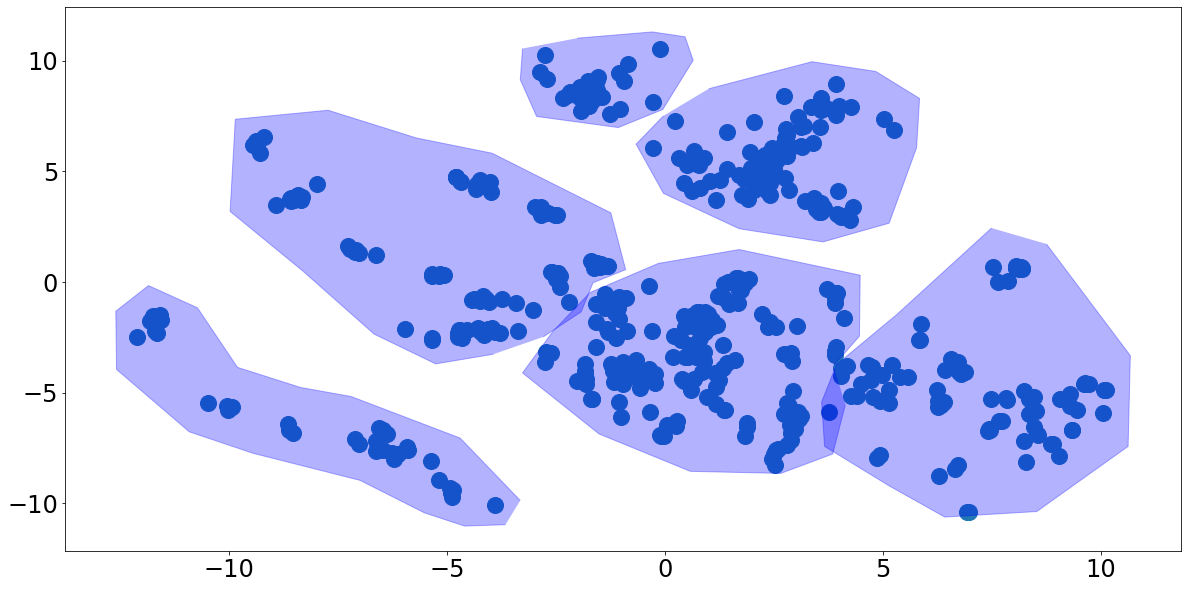

In [4]:
# Visualize the data and the marked clusters

plot_polys(data_rep, all_vertices)


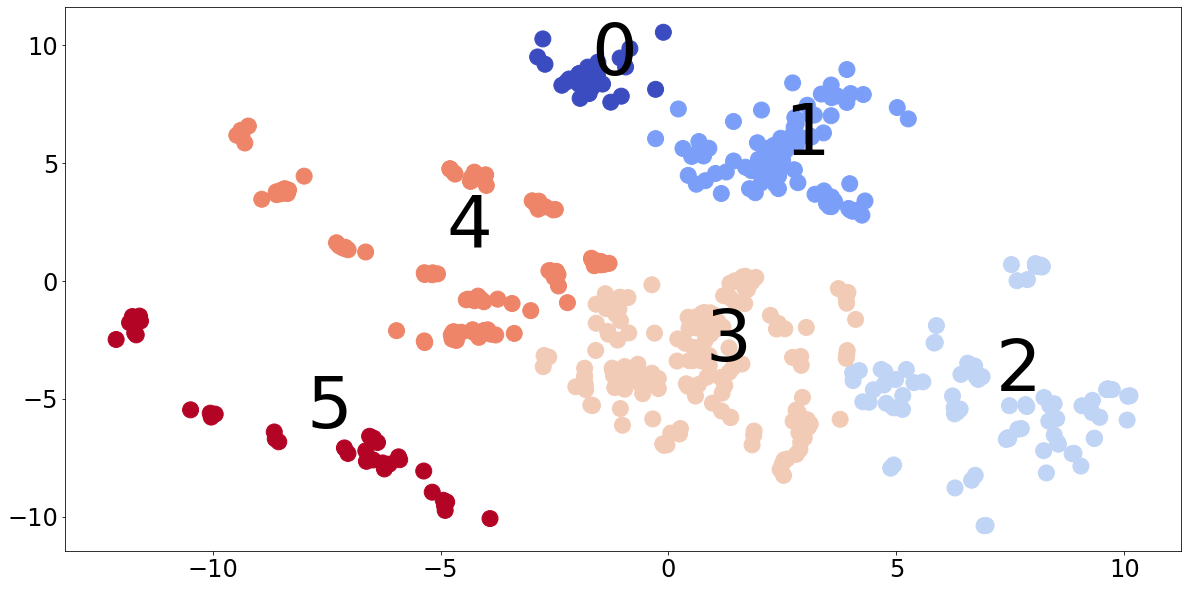

In [5]:
# Visualize the clusters in the learned representation

labels = poly2labels(data_rep, all_vertices)

means, centers, indices = plot_groups(x, data_rep, num_clusters, labels, name = "housing-rep.png")
 

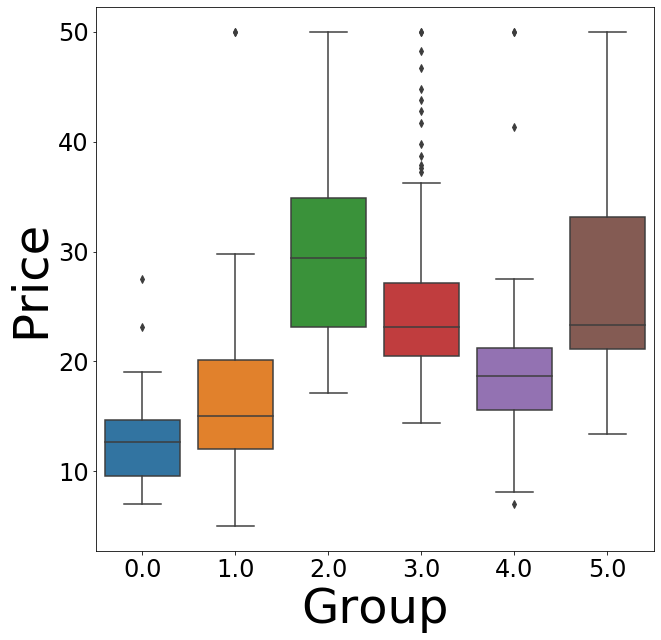

In [6]:
# See what signal is enocded in the clusters

import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(ax = ax, x = labels, y = np.squeeze(y))
ax.set(xlabel = "Group", ylabel = "Price")
ax.get_figure().savefig("housing-labels.png")

In [7]:
# Set epsilon for our metrics
epsilon = 1.5

if True:
    eval_epsilon(load_model, x, indices, epsilon)


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


In [8]:
# Compute the group explanations

best_val = 0.0
for i in range(ntrials):
    deltas = explain(load_model, means, centers, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
    a, b = metrics(load_model, x, indices, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas.npy", deltas)
    
    os.system("rm -rf explanation")


INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


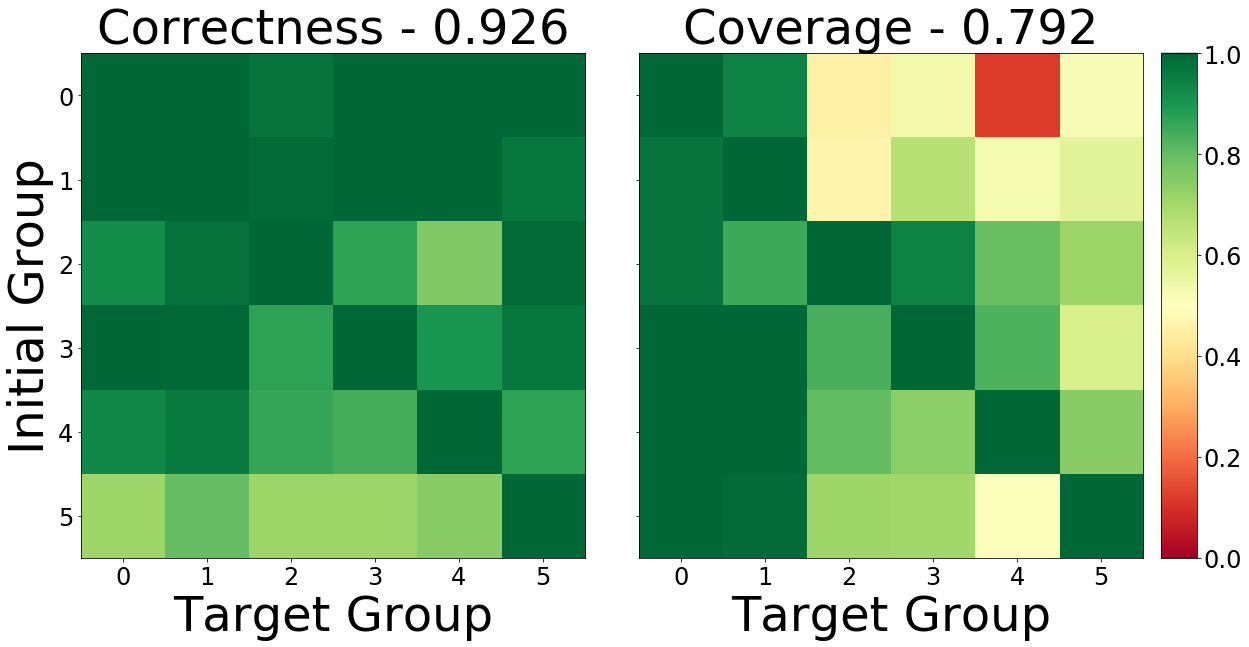

In [9]:
# Evaluate the explanations

deltas = np.load("deltas.npy")

a, b = metrics(load_model, x, indices, deltas, epsilon)

plot_metrics(a, b, name = "housing-metrics.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


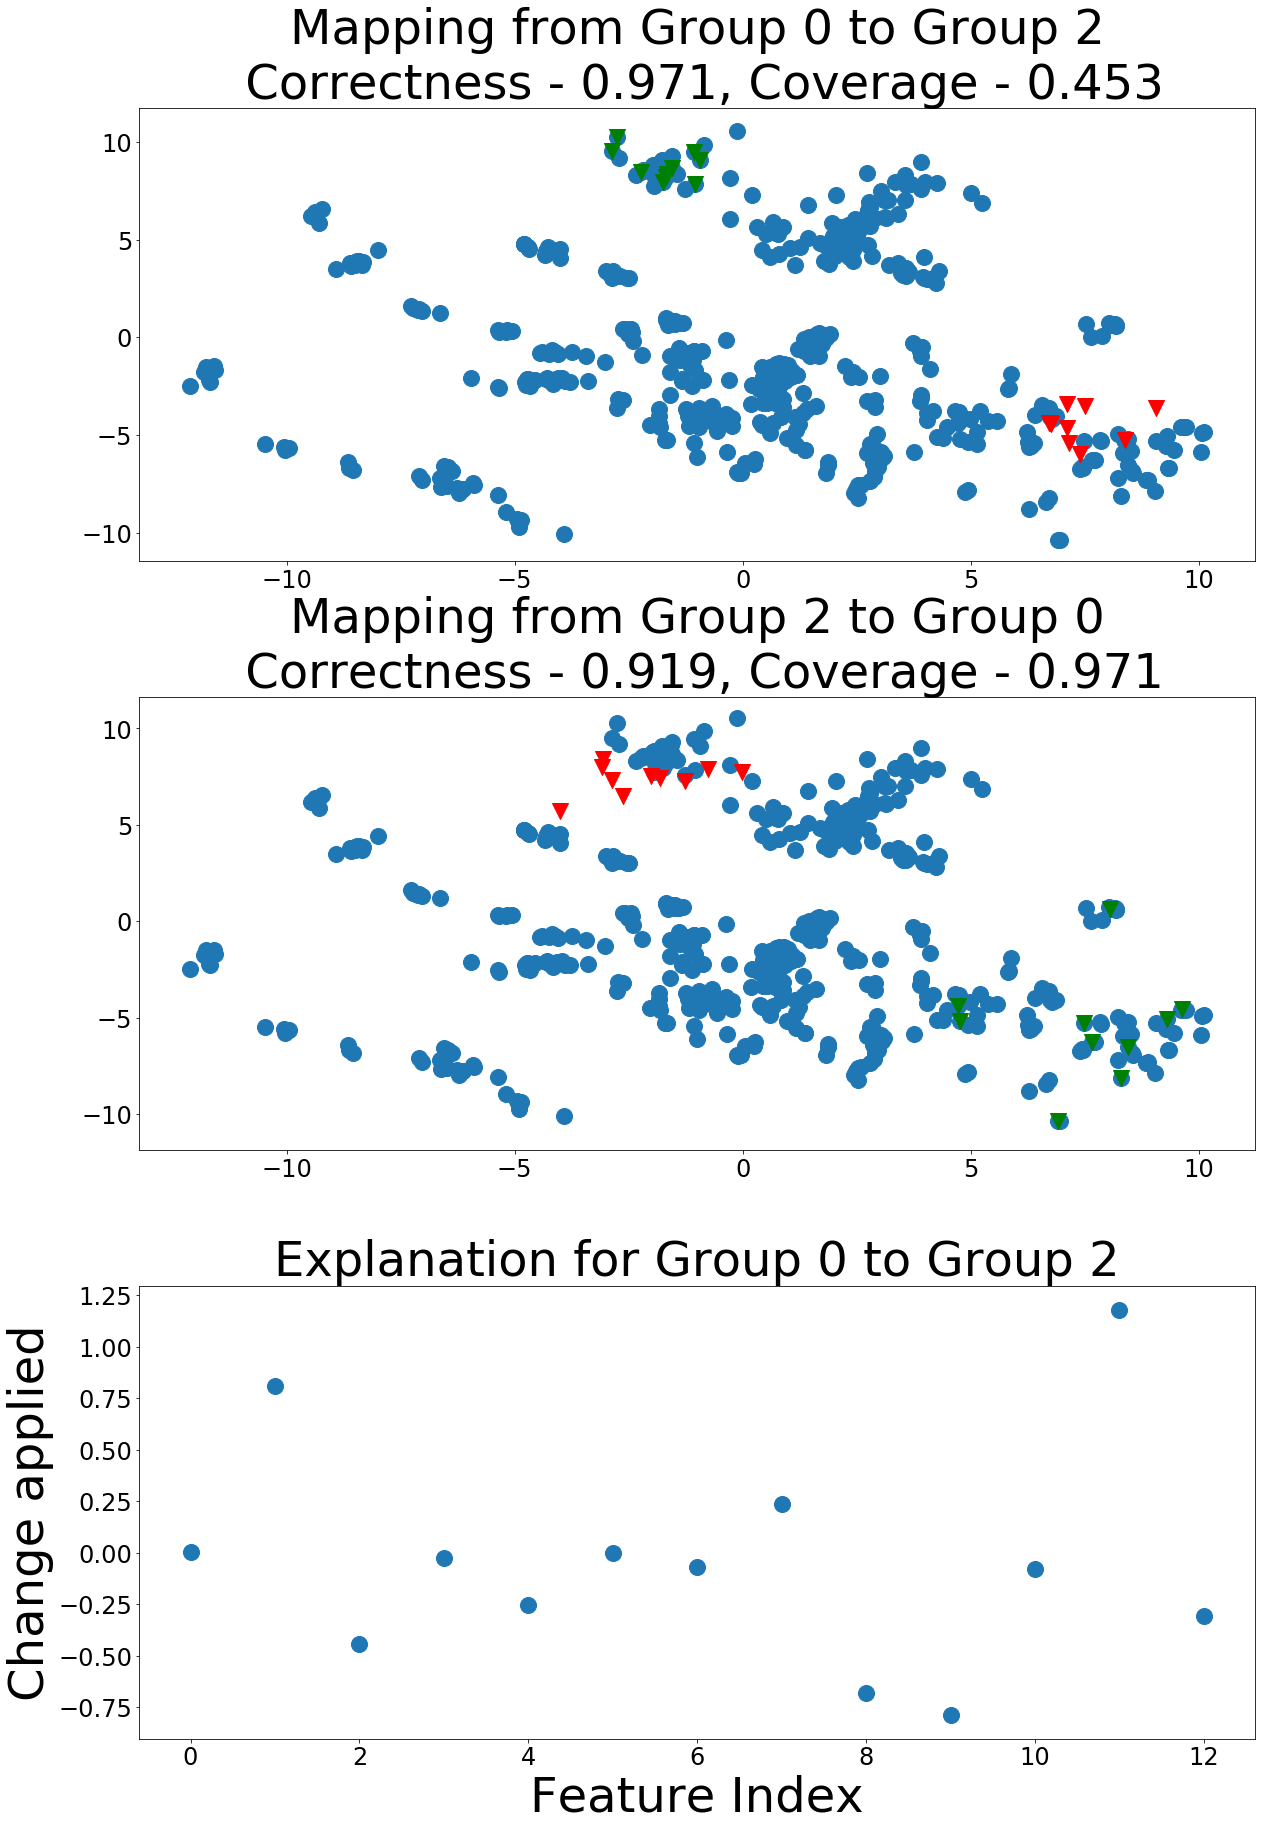

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


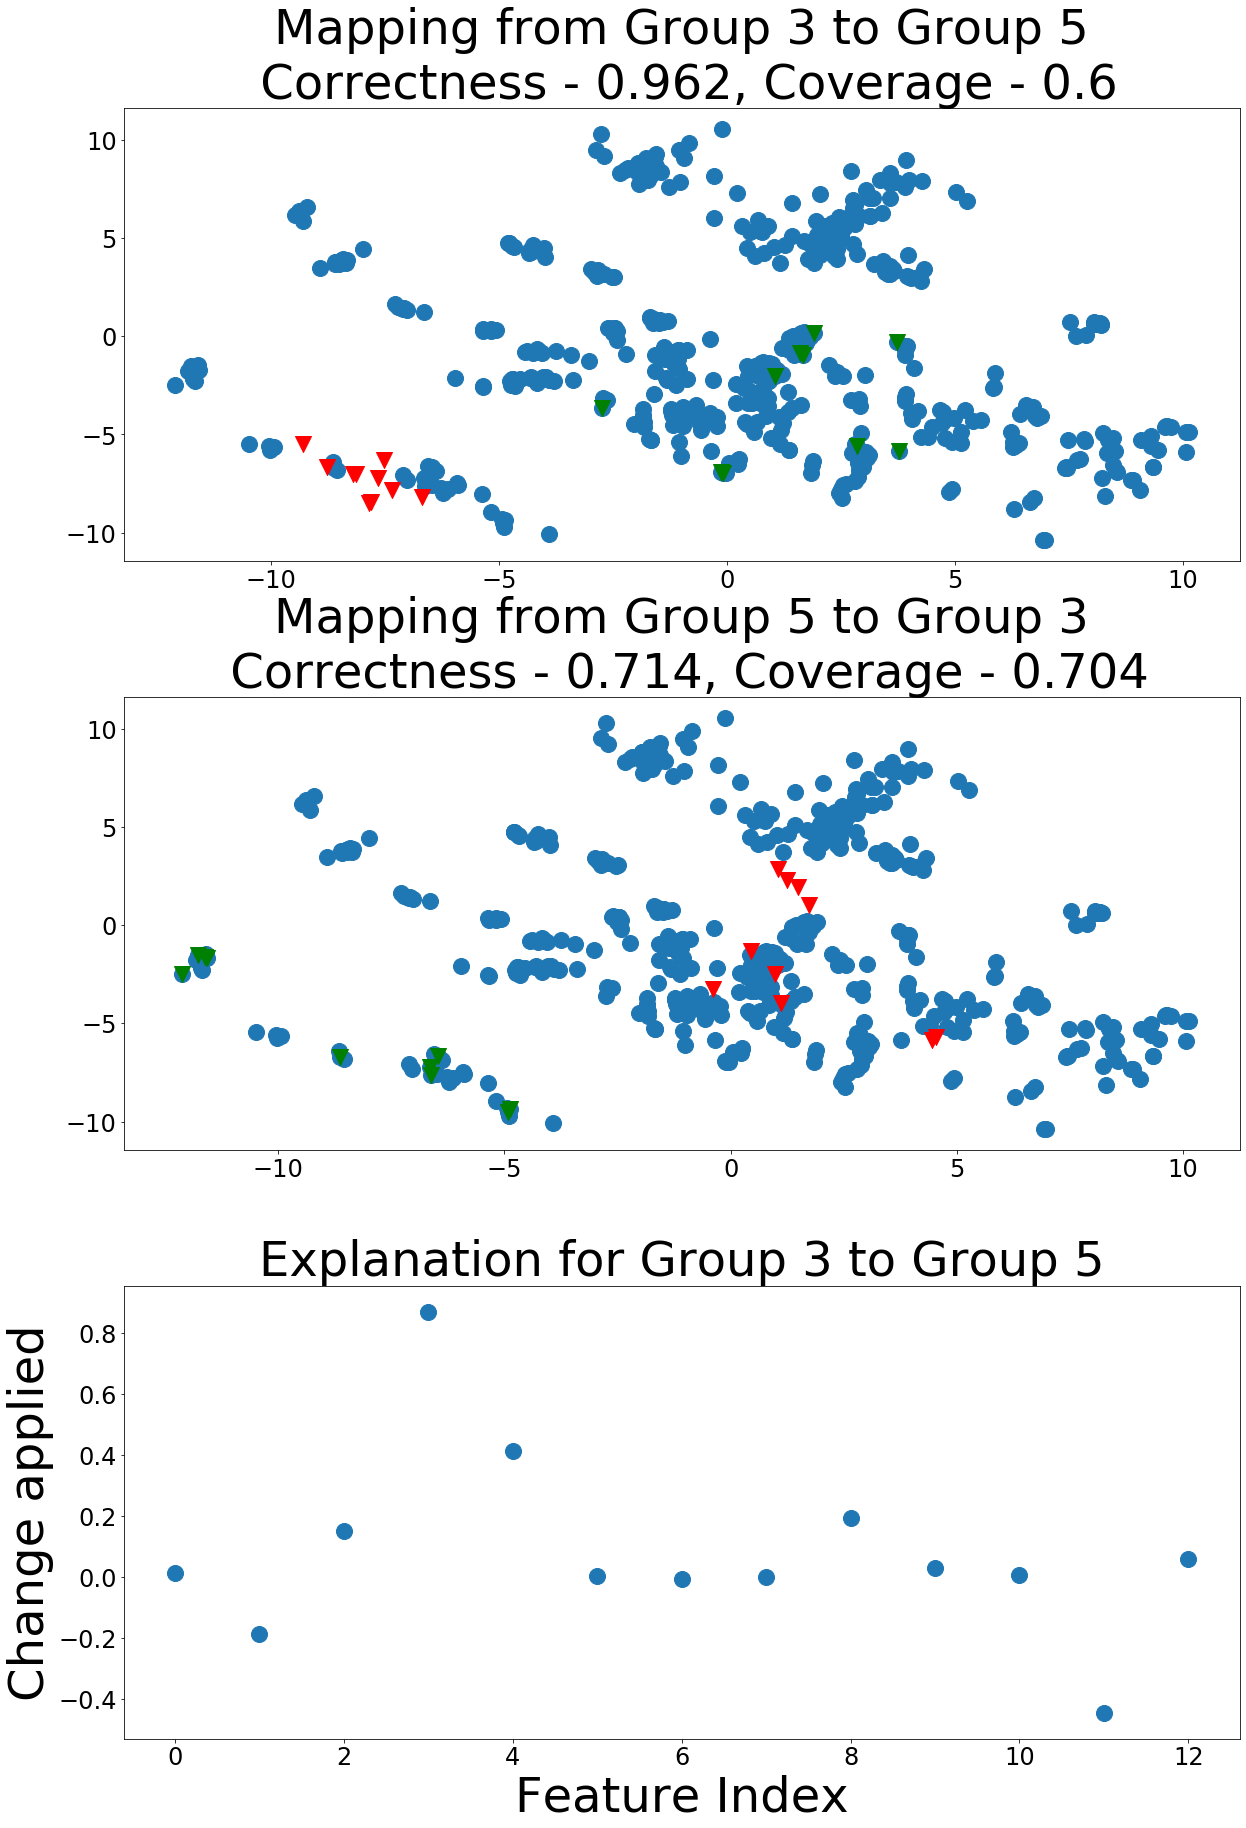

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


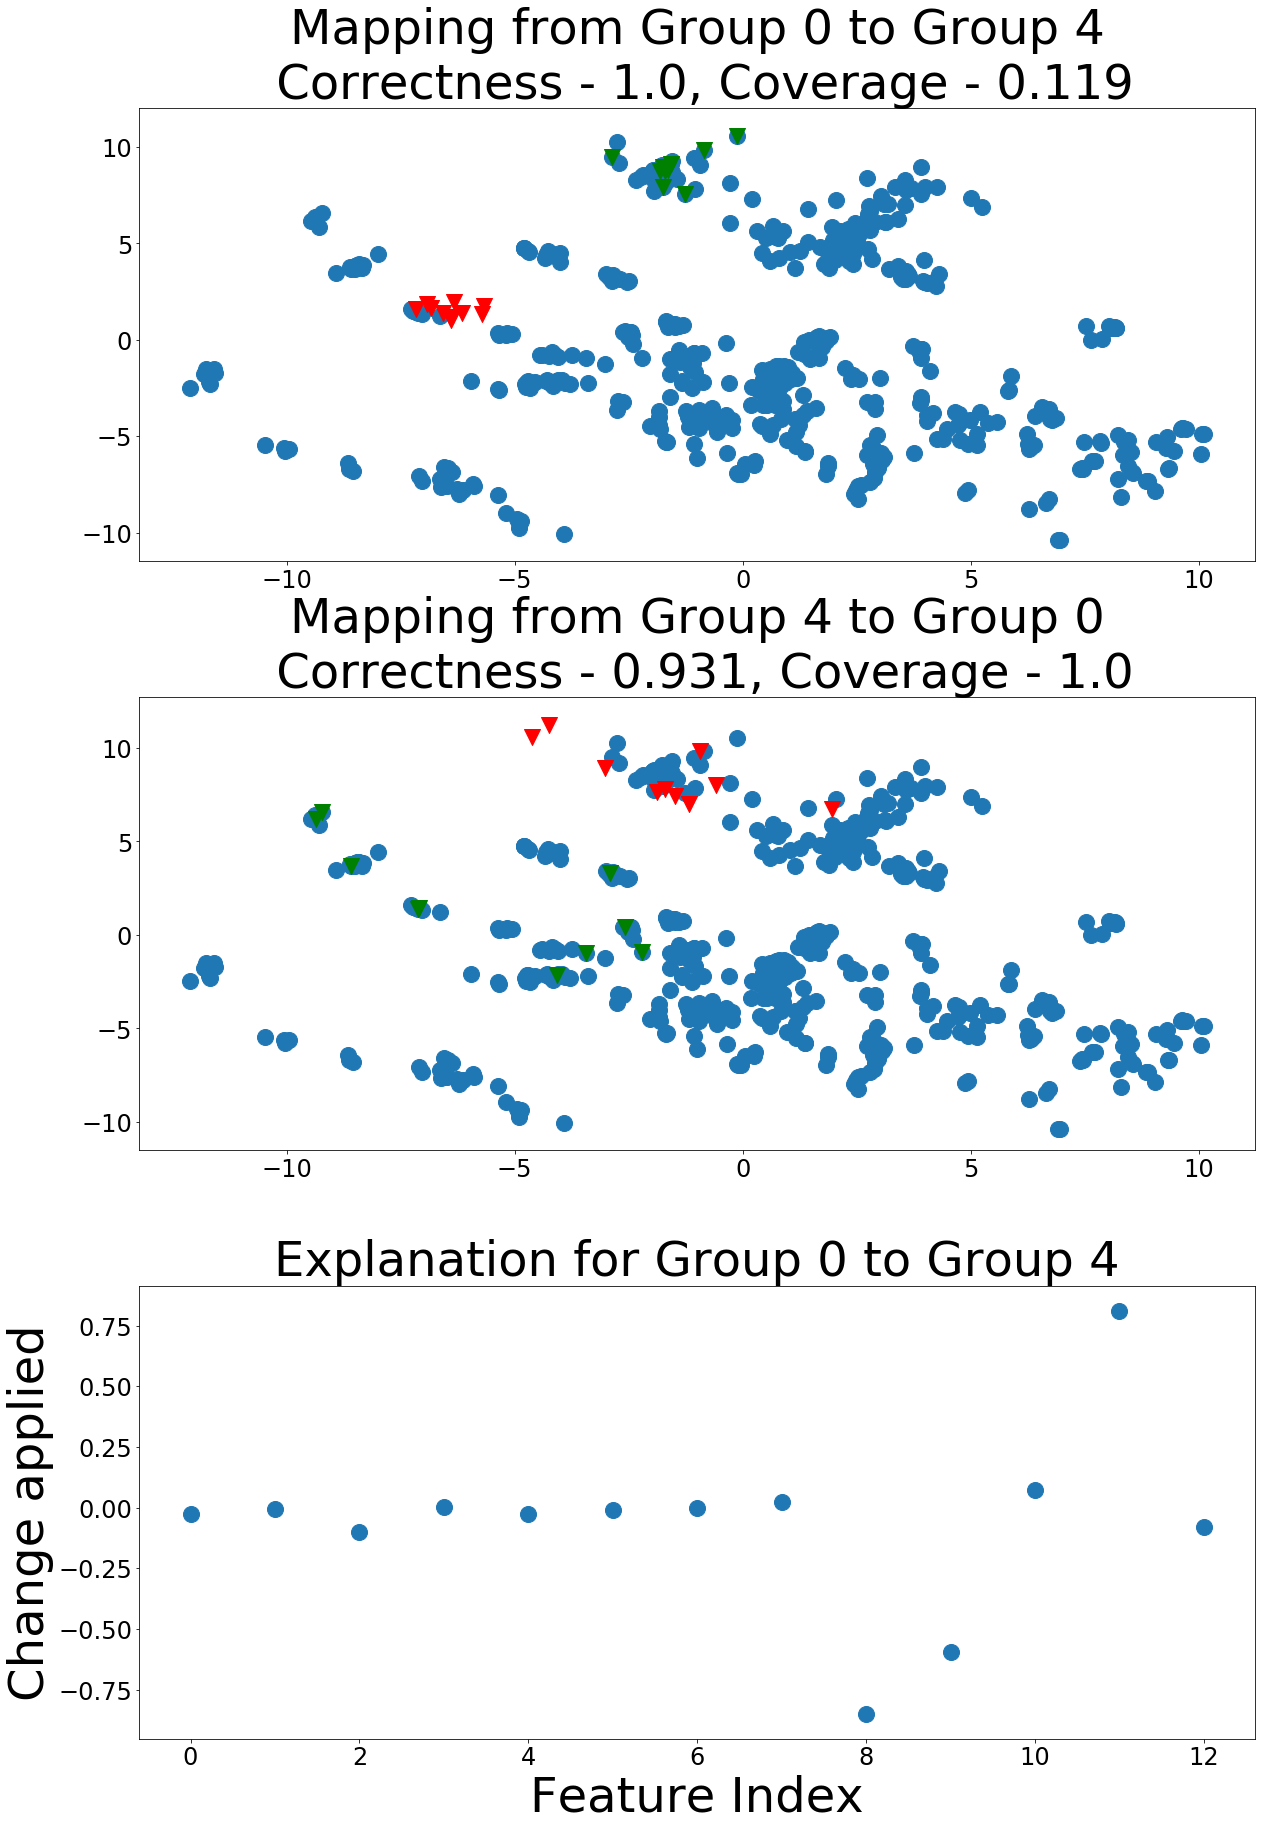

In [10]:
plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 2, num_points = 10, name = "housing-0to2.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 3, 5, num_points = 10, name = "housing-3to5.png")

plot_explanation(load_model, x, data_rep, indices, deltas, a, b, 0, 4, num_points = 10, name = "housing-0to4.png")


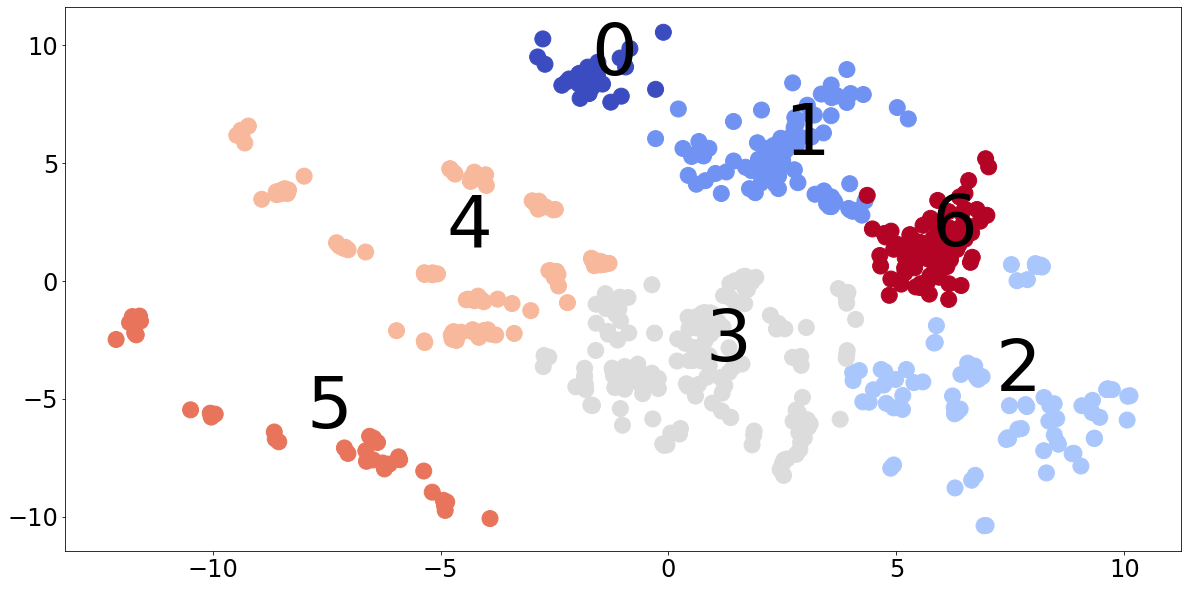

In [11]:
# Let's "corrupt" one of the groups

target_corrupted = 1

indices_corrupted = np.where(labels == target_corrupted)
n_corrupted = len(indices_corrupted[0])

x_corrupted = x[indices_corrupted]
x_corrupted[:, 9] -= 0.5 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)
x_corrupted[:, 1] += 0.9 + np.random.uniform(low = -0.1, high = 0.1, size = n_corrupted)

x_full = np.vstack((x, x_corrupted))

np.savetxt("Data/X_corrupted.tsv", x_full, delimiter = "\t")

labels_full = np.vstack((np.expand_dims(labels, 1), num_clusters * np.ones((n_corrupted,1))))

np.savetxt("Data/labels_corrupted.tsv", labels_full, delimiter = "\t")

# Compute the new representation
data_rep_full = sess.run(rep, feed_dict={X: x_full, D: np.zeros((1, input_dim))})

# Visualize the clusters in the learned representation
means_full, centers_full, indices_full = plot_groups(x_full, data_rep_full, num_clusters + 1, labels_full, name = "housing-rep-corrupted.png")


In [12]:
# Compute the group explanations

best_val = 0.0
for i in range(ntrials):
    deltas = explain(load_model, means_full, centers_full, learning_rate = 0.01, consecutive_steps = 5, lambda_global = lg)
    a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)
    
    val = np.mean(a)
    
    if val > best_val:
        best_val = val
        np.save("deltas_corrupted.npy", deltas)
    
    os.system("rm -rf explanation")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


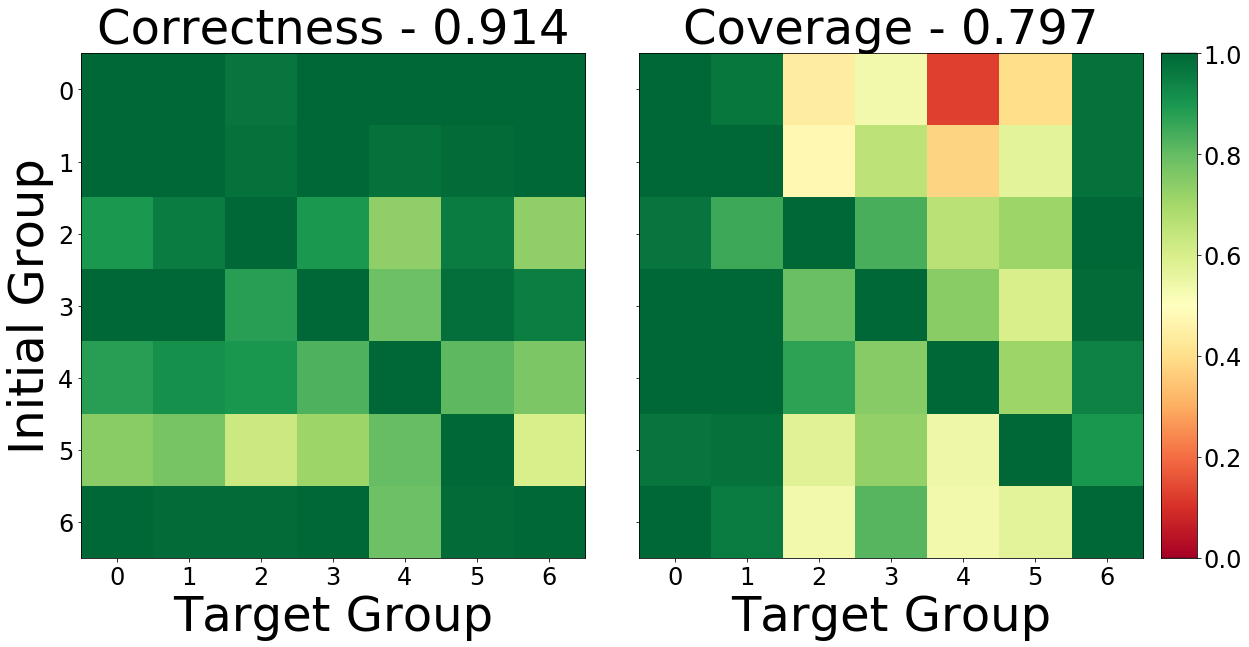

In [13]:
# Evaluate the explanations

deltas = np.load("deltas_corrupted.npy")

a, b = metrics(load_model, x_full, indices_full, deltas, epsilon)

plot_metrics(a, b, name = "housing-metrics-corrupted.png")

INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt
INFO:tensorflow:Restoring parameters from /home/gregory/Desktop/ELDR/Housing/Model/model/perplexity_10_regularizer_0.001_batch_size_505_learning_rate_0.01_latent_dimension_2_activation_ELU_seed_1_iter_3000.ckpt


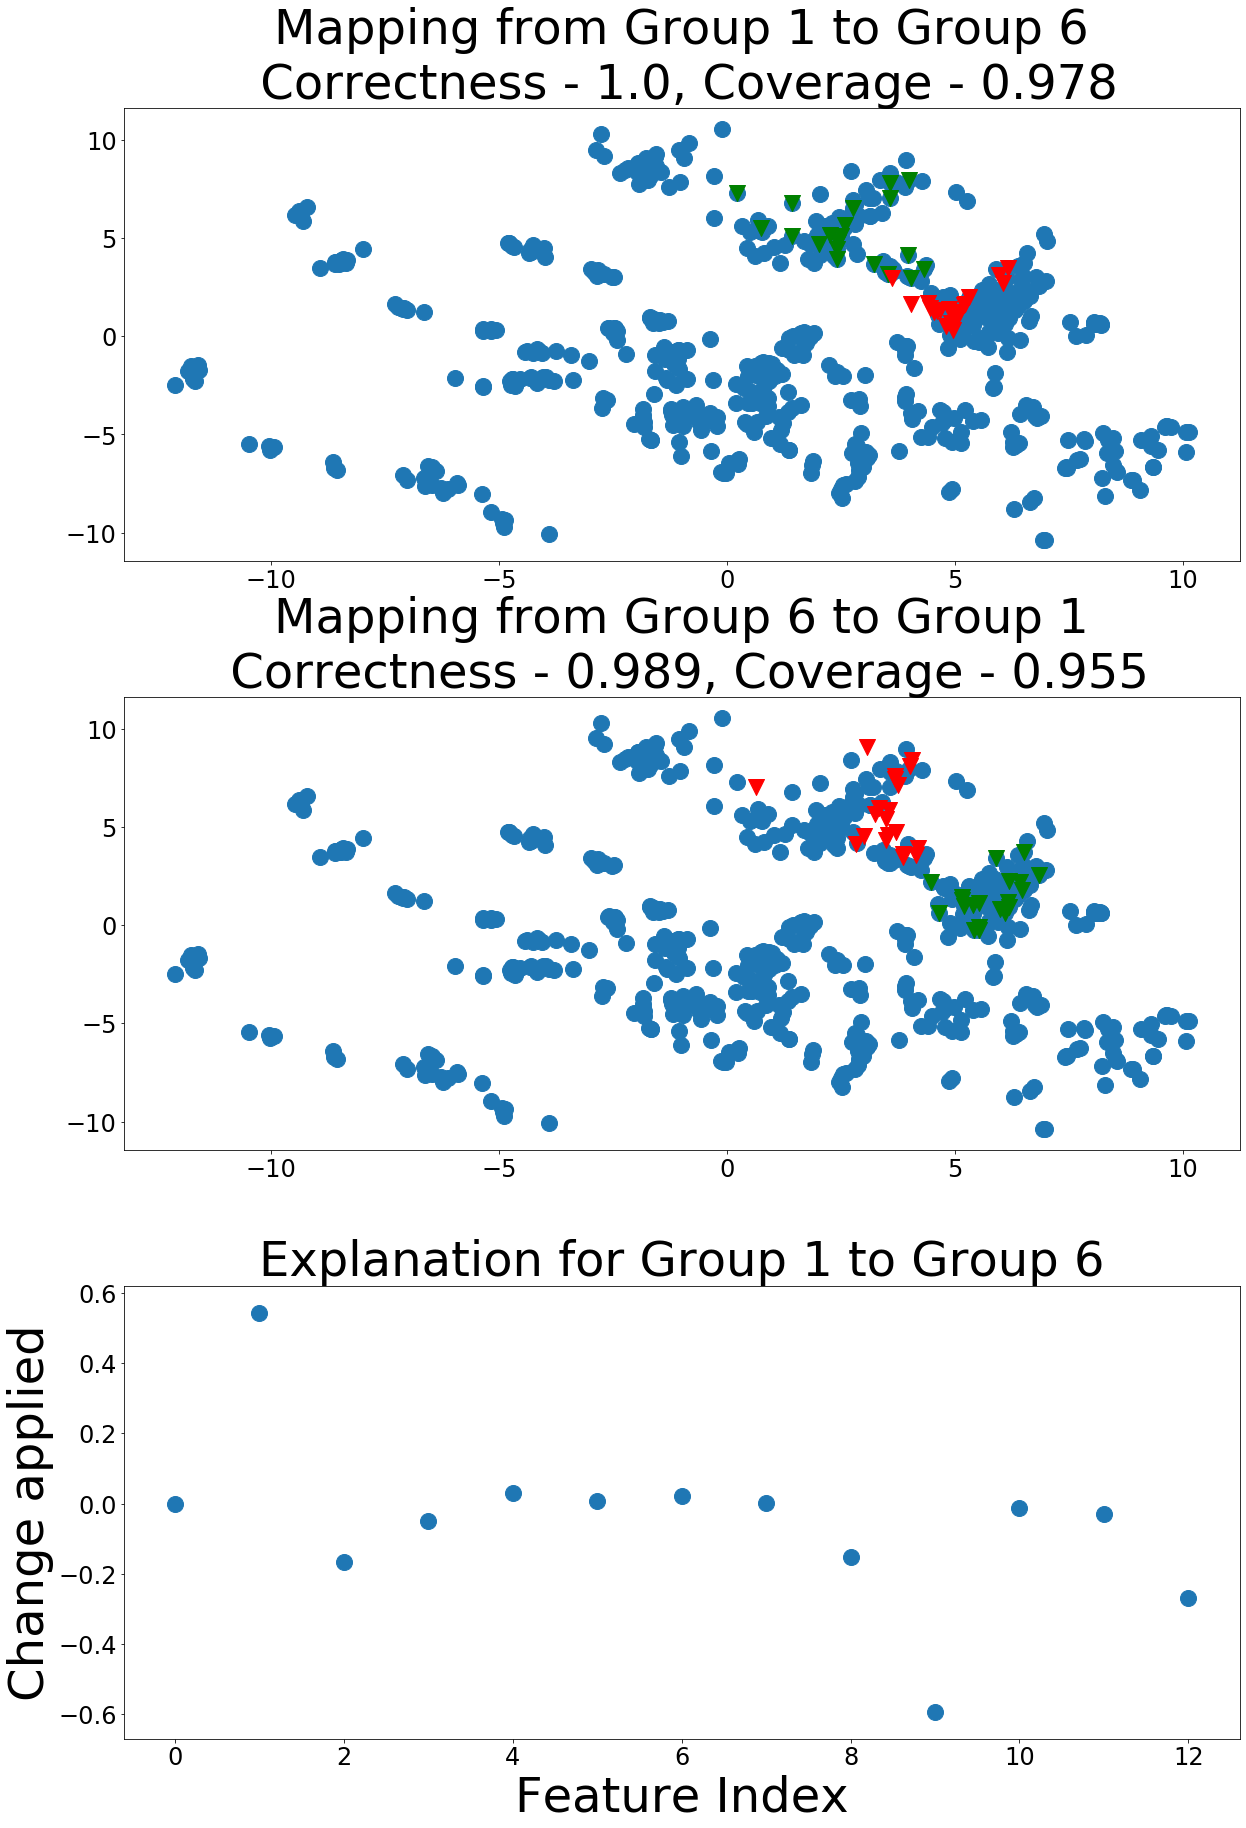

In [14]:
# Check if we found the corruption

plot_explanation(load_model, x_full, data_rep_full, indices_full, deltas, a, b, target_corrupted, num_clusters, name = "housing-t2c.png", num_points = 20)


[[ 0.   -0.   -0.18 -0.01 -0.01  0.   -0.05  0.   -0.06 -0.02 -0.02  0.76
   0.  ]
 [ 0.    0.81 -0.45 -0.02 -0.25 -0.   -0.07  0.24 -0.68 -0.79 -0.08  1.18
  -0.31]
 [-0.01  0.21 -0.3  -0.01 -0.42 -0.    0.    0.11 -0.77 -0.77 -0.01  1.14
  -0.37]
 [-0.03 -0.01 -0.1   0.   -0.03 -0.01 -0.    0.02 -0.85 -0.59  0.07  0.81
  -0.08]
 [ 0.    0.02 -0.15  0.86 -0.    0.   -0.01  0.11 -0.58 -0.74 -0.    0.69
  -0.31]]
[[ 0.02 -0.04 -0.2  -0.   -0.03 -0.01 -0.06  0.   -0.08  0.02 -0.01  0.73
   0.05]
 [-0.04  0.77 -0.43 -0.11 -0.22  0.   -0.13  0.31 -0.7  -0.74 -0.05  1.11
  -0.3 ]
 [-0.06  0.2  -0.35  0.03 -0.35  0.01 -0.06  0.06 -0.74 -0.72  0.01  1.07
  -0.38]
 [-0.12 -0.03 -0.17 -0.02 -0.01 -0.01 -0.01 -0.01 -0.8  -0.62  0.02  0.71
  -0.15]
 [-0.02  0.06 -0.21  0.9   0.   -0.   -0.04  0.02 -0.55 -0.67  0.03  0.71
  -0.21]]


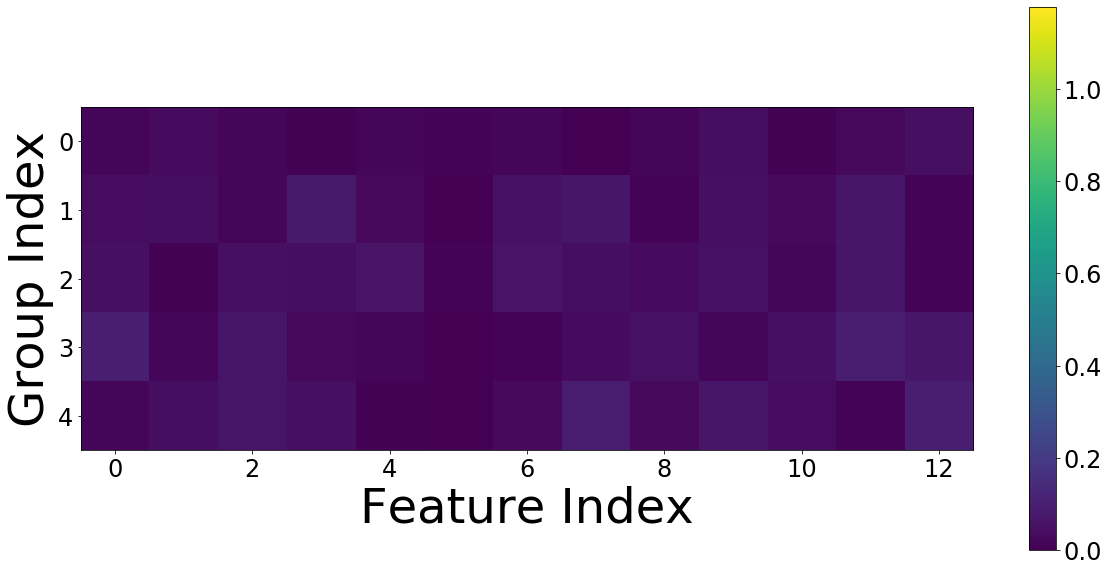

In [15]:
# Evaluate how much the other explanations changed

deltas_original = np.load("deltas.npy")

plot_similarity(deltas, deltas_original, "housing-corrupted-similarity.png")
